In [28]:
# Prepare gym for agent
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Getting enviroment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [29]:
print(env.action_space)
env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state)

Discrete(2)
[ 0.03058785 -0.15412635 -0.01584764  0.24713909]


Two possible actions [0,1]
State descrived by [position of cart, velocity of cart, angle of pole, rotation rate of pole].

Neural Network implementation to approximate the Q action value function.

## Experience Replay memory implementation.

In [30]:
from collections import deque
class Memory_exp_replay:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add_timestep(self, env_reaction):
        # St, At, Rt1, St1.
        self.buffer.append(env_reaction)
        
    def sample_random(self, sample_size, debug=False):
        # Replace=False, important so it doesn't repeat a sample on the batch
        indexs = np.random.choice(a=np.arange(len(self.buffer)), size=sample_size, replace=False) 
        if debug:
            print(indexs)
        states = list()
        actions = list()
        rewards = list()
        next_states = list()
        for index in indexs:
            states.append(self.buffer[index][0])
            actions.append(self.buffer[index][1])
            rewards.append(self.buffer[index][2])
            next_states.append(self.buffer[index][3])
        batch = [np.array(states), np.array(actions), np.array(rewards), np.array(next_states)]
        return batch

Testing out the Memory Buffer.

In [31]:
# Initliaze memory
def populate_memory(env, exp_replay_memory, batch_size_Q, debug=False):
    if debug: 
        print('Order of enviroment reactions')
    content = 0
    s_t1 = env.reset()
    while content < batch_size_Q:
        s_t = s_t1 
        a_t = env.action_space.sample()
        s_t1, r_t1, done, info = env.step(a_t)
        if done:
            s_t1 = np.zeros(s_t.shape)
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
            s_t = env.reset()
        else:
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
        content += 1
    return exp_replay_memory

memory_size = 100000
batch_size_Q = 20

# Intantiate memory and populate
exp_replay = Memory_exp_replay(memory_size)
exp_replay = populate_memory(env, exp_replay, batch_size_Q, debug=True)

print('Random sample from Memory Buffer')
states, actions, rewards, next_states = exp_replay.sample_random(2, debug=True)
for state in states:
    print(state)

Order of enviroment reactions
0 [ 0.00715869  0.01008044  0.04222421 -0.03998971]
1 [ 0.0073603   0.20457226  0.04142442 -0.31905719]
2 [ 0.01145174  0.39908051  0.03504327 -0.59839397]
3 [ 0.01943335  0.59369506  0.02307539 -0.87983596]
4 [ 0.03130725  0.39826733  0.00547867 -0.57998884]
5 [ 0.0392726   0.59331208 -0.0061211  -0.87094085]
6 [ 0.05113884  0.39827392 -0.02353992 -0.58018868]
7 [ 0.05910432  0.20348961 -0.03514369 -0.29501326]
8 [ 0.06317411  0.3990945  -0.04104396 -0.59856955]
9 [ 0.071156    0.59476597 -0.05301535 -0.90389311]
10 [ 0.08305132  0.79056435 -0.07109321 -1.21275724]
11 [ 0.09886261  0.5964283  -0.09534836 -0.94317256]
12 [ 0.11079117  0.79269662 -0.11421181 -1.26422777]
13 [ 0.12664511  0.989078   -0.13949636 -1.590386  ]
14 [ 0.14642667  0.795861   -0.17130408 -1.34425487]
15 [ 0.16234389  0.99267292 -0.19818918 -1.68526917]
16 [0. 0. 0. 0.]
17 [ 0.03665265  0.17347703 -0.04523727 -0.33084363]
18 [ 0.04012219  0.36921275 -0.05185414 -0.63744206]
19 [ 0.04

### Memory working well.

## Q Value Neural Network inference.

In [32]:
# Defining NN for the action value function approximation.
class NN_Q_approx:
    def __init__(self, learning_rate, hidden_size, state_space, action_space, name):
        self.learning_rate = learning_rate
        self.state_space = state_space
        self.action_space = action_space
        self.name = name
        with tf.variable_scope(self.name):
            self.inputs = tf.placeholder(dtype=tf.float32, shape=[None, self.state_space], name='state_input')
            
            # Placeholder to choose the action value for the action done.
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='action_output')
            actions_oh = tf.one_hot(self.actions, self.action_space)
            
            self.target_Q = tf.placeholder(dtype=tf.float32, shape= [None], name='target_Q')
            
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs, hidden_size, scope='fc1')
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 2*hidden_size, scope='fc2')
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size, scope='fc3')
            self.output = tf.contrib.layers.fully_connected(self.fc3, self.action_space, activation_fn=None, scope='output')
            # Until here for action value prediction.
            
            # Q size [m, action_space] -> sum, size [m, 1]
            self.Q = tf.reduce_sum(tf.multiply(self.output, actions_oh), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.Q - self.target_Q))
            self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)     
            

Defining parameters for neural network and replay memory, to test out how NN performs to learn Q values.

In [33]:
# NN parameters.
learning_rate_nn = 0.0001
hidden_size = 128
state_space = len(state)
action_space = env.action_space.n

# Memory parameters.
memory_size = 100000
batch_size_Q = 32

# Training parameters.
max_episodes = 3000
max_steps_episode = 200
gamma = 1

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.05

# Update Target NN weights every X steps.
update_nn_target = 5

Defining Epislon-Greedy Policy and Weigth update for the Target NN.

In [34]:
def epsilon_greedy(epsilon, q_value):
    probabilities = np.ones(q_value[0].shape)*epsilon/action_space
    probabilities[np.argmax(q_value[0])] = 1 - epsilon + (epsilon/action_space)
    action = np.random.choice(a=np.arange(action_space), size=1, p=probabilities)
    return int(action)


# If I don't assign the value and variable relationship before each iteration, it is incredibly slow.
# Assigning the relationship of the graph and just updating the value is much faster.
def relate_variables_NN(Q_NN_target, Q_NN_grad):
    assigns = list()
    Q_NN_grad_variables =[v for v in tf.trainable_variables() if Q_NN_grad.name in v.name]
    Q_NN_target_variables =[v for v in tf.trainable_variables() if Q_NN_target.name in v.name]
#     Q_NN_grad_values = sess.run(Q_NN_grad_variables)
    for ind_g, var in enumerate(Q_NN_grad_variables):
        for var_target in Q_NN_target_variables:
            if var_target.name.replace(Q_NN_target.name,Q_NN_grad.name)==var.name:
#                 assigns.append(tf.assign(var_target, Q_NN_grad_values[ind_g]))
                assigns.append(tf.assign(var_target, var.value()))
                break

    return assigns

def update_values_sess(sess, assigns):
    for assign_oper in assigns:
        sess.run(assign_oper)

Code to run training.

In [35]:
def train_agent():
    # Intantiate memory and populate
    exp_replay = Memory_exp_replay(memory_size)
    exp_replay = populate_memory(env, exp_replay, batch_size_Q)

    # Initiliaze TensorFlow Graph
    tf.reset_default_graph()
    Q_NN_target = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_target')
    Q_NN_grad = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_grad')
    assigns = relate_variables_NN(Q_NN_target, Q_NN_grad)

    training_rewards = list()
    training_loss = list()
    with tf.Session() as sess:
        # Initializa variables 
        sess.run(tf.global_variables_initializer())
        ep_iter = 0

        for i in range(1, max_episodes+1):
            # Intiliazing variables for episode.
            s_t1 = env.reset()
            time_step = 0
            episode_reward = 0

            while time_step < max_steps_episode:
                # Watch it learn.
                # env.render()

                s_t = s_t1
                # Controling epsilon.
                ep_iter += 1
                epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*i) 

                # Find Q Values and select action under E-greedy policy.
                q_values = sess.run(Q_NN_grad.output, feed_dict={Q_NN_grad.inputs:np.array(s_t).reshape((1, -1))})
                a_t = epsilon_greedy(epsilon, q_values)

                s_t1, r_t1, done, info = env.step(a_t)

                episode_reward += gamma*r_t1
                time_step += 1

                if done:
                    # Terminating episode
                    time_step = max_steps_episode
                    s_t1 = np.zeros(state_space)
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                    # Tracking information
                    training_rewards.append((i, episode_reward))
                    training_loss.append((i, loss))
                    print('Episode: {}'.format(i),


                          'Total reward: {:.4f}'.format(episode_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Epsilon: {:.4f}'.format(epsilon))
                else:
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                # Train network.
                states, actions, rewards, next_states = exp_replay.sample_random(batch_size_Q)

                estimated_Qs = sess.run(Q_NN_target.output, feed_dict = {Q_NN_target.inputs:next_states})
                action_Qs = sess.run(Q_NN_grad.output, feed_dict = {Q_NN_grad.inputs:next_states})
                found_initial = (next_states == np.zeros(states[0].shape)).all(axis=1)
                estimated_Qs[found_initial] = np.zeros(estimated_Qs[0].shape)
                action_Qs[found_initial] = np.zeros(estimated_Qs[0].shape)

                actions_t = (action_Qs==np.amax(action_Qs, axis=1, keepdims=True))
                target_Qs = rewards + gamma*np.max(estimated_Qs*actions_t, axis=1)

                feed_dict = {Q_NN_grad.inputs:states, Q_NN_grad.actions:actions, Q_NN_grad.target_Q: target_Qs}
                loss, _ = sess.run([Q_NN_grad.loss, Q_NN_grad.opt], feed_dict)

                if ep_iter%update_nn_target==0:
                    update_values_sess(sess, assigns)

                if (len(training_rewards)>=100) and (np.array(training_rewards[-100:])>= 195).all():
                    print('Gym solved!')
                    print('Final Episode:', i)
                    return training_loss, training_rewards
    return training_loss, training_rewards

training_loss, training_rewards = train_agent()

Episode: 1 Total reward: 23.0000 Training loss: 1.0463 Epsilon: 0.9517
Episode: 2 Total reward: 34.0000 Training loss: 1.1064 Epsilon: 0.9058
Episode: 3 Total reward: 10.0000 Training loss: 1.0883 Epsilon: 0.8621
Episode: 4 Total reward: 11.0000 Training loss: 1.3226 Epsilon: 0.8205
Episode: 5 Total reward: 14.0000 Training loss: 1.6325 Epsilon: 0.7810
Episode: 6 Total reward: 19.0000 Training loss: 1.7054 Epsilon: 0.7434
Episode: 7 Total reward: 13.0000 Training loss: 2.0638 Epsilon: 0.7076
Episode: 8 Total reward: 20.0000 Training loss: 4.1626 Epsilon: 0.6736
Episode: 9 Total reward: 20.0000 Training loss: 4.3508 Epsilon: 0.6413
Episode: 10 Total reward: 30.0000 Training loss: 19.1005 Epsilon: 0.6105
Episode: 11 Total reward: 14.0000 Training loss: 16.1310 Epsilon: 0.5812
Episode: 12 Total reward: 10.0000 Training loss: 11.4382 Epsilon: 0.5533
Episode: 13 Total reward: 25.0000 Training loss: 95.2894 Epsilon: 0.5268
Episode: 14 Total reward: 12.0000 Training loss: 49.1709 Epsilon: 0.5

Episode: 115 Total reward: 22.0000 Training loss: 42.9857 Epsilon: 0.0132
Episode: 116 Total reward: 20.0000 Training loss: 174.5143 Epsilon: 0.0130
Episode: 117 Total reward: 22.0000 Training loss: 74.6349 Epsilon: 0.0129
Episode: 118 Total reward: 19.0000 Training loss: 23.9269 Epsilon: 0.0127
Episode: 119 Total reward: 21.0000 Training loss: 44.5627 Epsilon: 0.0126
Episode: 120 Total reward: 20.0000 Training loss: 132.4337 Epsilon: 0.0125
Episode: 121 Total reward: 25.0000 Training loss: 11.5140 Epsilon: 0.0123
Episode: 122 Total reward: 32.0000 Training loss: 122.9443 Epsilon: 0.0122
Episode: 123 Total reward: 19.0000 Training loss: 93.0540 Epsilon: 0.0121
Episode: 124 Total reward: 41.0000 Training loss: 30.7778 Epsilon: 0.0120
Episode: 125 Total reward: 40.0000 Training loss: 61.7643 Epsilon: 0.0119
Episode: 126 Total reward: 31.0000 Training loss: 5.9118 Epsilon: 0.0118
Episode: 127 Total reward: 41.0000 Training loss: 186.3863 Epsilon: 0.0117
Episode: 128 Total reward: 32.0000 

Episode: 225 Total reward: 200.0000 Training loss: 56.9422 Epsilon: 0.0100
Episode: 226 Total reward: 173.0000 Training loss: 16.8076 Epsilon: 0.0100
Episode: 227 Total reward: 200.0000 Training loss: 196.7849 Epsilon: 0.0100
Episode: 228 Total reward: 200.0000 Training loss: 29.4141 Epsilon: 0.0100
Episode: 229 Total reward: 200.0000 Training loss: 810.8082 Epsilon: 0.0100
Episode: 230 Total reward: 200.0000 Training loss: 39.4788 Epsilon: 0.0100
Episode: 231 Total reward: 200.0000 Training loss: 113.5783 Epsilon: 0.0100
Episode: 232 Total reward: 200.0000 Training loss: 4513.6152 Epsilon: 0.0100
Episode: 233 Total reward: 200.0000 Training loss: 159.0254 Epsilon: 0.0100
Episode: 234 Total reward: 200.0000 Training loss: 151.3783 Epsilon: 0.0100
Episode: 235 Total reward: 200.0000 Training loss: 94.9043 Epsilon: 0.0100
Episode: 236 Total reward: 200.0000 Training loss: 5058.7046 Epsilon: 0.0100
Episode: 237 Total reward: 200.0000 Training loss: 6178.4131 Epsilon: 0.0100
Episode: 238 T

Episode: 333 Total reward: 200.0000 Training loss: 523.0735 Epsilon: 0.0100
Episode: 334 Total reward: 200.0000 Training loss: 2091.5845 Epsilon: 0.0100
Episode: 335 Total reward: 200.0000 Training loss: 288014.9062 Epsilon: 0.0100
Episode: 336 Total reward: 200.0000 Training loss: 6445.9160 Epsilon: 0.0100
Episode: 337 Total reward: 200.0000 Training loss: 5540.6689 Epsilon: 0.0100
Episode: 338 Total reward: 200.0000 Training loss: 10165.0938 Epsilon: 0.0100
Episode: 339 Total reward: 200.0000 Training loss: 11856.6699 Epsilon: 0.0100
Episode: 340 Total reward: 200.0000 Training loss: 10565.4551 Epsilon: 0.0100
Episode: 341 Total reward: 200.0000 Training loss: 10987.9131 Epsilon: 0.0100
Episode: 342 Total reward: 200.0000 Training loss: 12132.3545 Epsilon: 0.0100
Episode: 343 Total reward: 200.0000 Training loss: 39613.8242 Epsilon: 0.0100
Episode: 344 Total reward: 200.0000 Training loss: 10960.1494 Epsilon: 0.0100
Episode: 345 Total reward: 200.0000 Training loss: 14840.3320 Epsilo

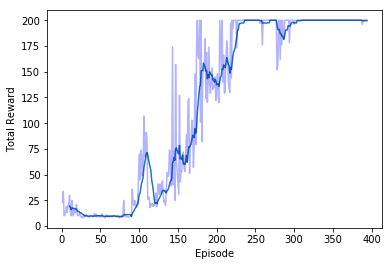

In [36]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(training_rewards).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='blue', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

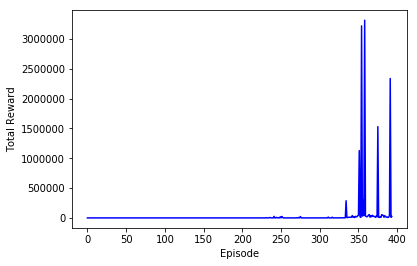

In [37]:
eps, loss = np.array(training_loss).T
plt.plot(loss, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
def train_agent():
    # Intantiate memory and populate
    exp_replay = Memory_exp_replay(memory_size)
    exp_replay = populate_memory(env, exp_replay, batch_size_Q)

    # Initiliaze TensorFlow Graph
    tf.reset_default_graph()
    Q_NN_1 = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_target')
    Q_NN_2 = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_grad')
    nns = [Q_NN_1, Q_NN_2]


    training_rewards = list()
    training_loss = list()
    with tf.Session() as sess:
        # Initializa variables 
        sess.run(tf.global_variables_initializer())
        ep_iter = 0

        for i in range(1, max_episodes+1):
            # Intiliazing variables for episode.
            s_t1 = env.reset()
            time_step = 0
            episode_reward = 0

            while time_step < max_steps_episode:
                # Watch it learn.
                # env.render()

                nn_ind = int(np.random.choice(a=2, size=1))
                action_nn = nns[nn_ind]
                target_nn = nns[not(nn_ind)]

                s_t = s_t1
                # Controling epsilon.
                ep_iter += 1
                epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*i) 

                # Find Q Values and select action under E-greedy policy.
                q_values = sess.run(action_nn.output, feed_dict={action_nn.inputs:np.array(s_t).reshape((1, -1))})
                a_t = epsilon_greedy(epsilon, q_values)

                s_t1, r_t1, done, info = env.step(a_t)

                episode_reward += gamma*r_t1
                time_step += 1

                if done:
                    # Terminating episode
                    time_step = max_steps_episode
                    s_t1 = np.zeros(state_space)
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                    # Tracking information
                    training_rewards.append((i, episode_reward))
                    training_loss.append((i, loss))
                    print('Episode: {}'.format(i),


                          'Total reward: {:.4f}'.format(episode_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Epsilon: {:.4f}'.format(epsilon))
                else:
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                # Train network.
                states, actions, rewards, next_states = exp_replay.sample_random(batch_size_Q)

                estimated_Qs = sess.run(target_nn.output, feed_dict = {target_nn.inputs:next_states})
                action_Qs = sess.run(action_nn.output, feed_dict = {action_nn.inputs:next_states})
                found_initial = (next_states == np.zeros(states[0].shape)).all(axis=1)
                estimated_Qs[found_initial] = np.zeros(estimated_Qs[0].shape)
                action_Qs[found_initial] = np.zeros(estimated_Qs[0].shape)
                actions_t = (action_Qs==np.amax(action_Qs, axis=1, keepdims=True))

                target_Qs = rewards + gamma*np.max(estimated_Qs*actions_t, axis=1)

                feed_dict = {action_nn.inputs:states, action_nn.actions:actions, action_nn.target_Q: target_Qs}
                loss, _ = sess.run([action_nn.loss, action_nn.opt], feed_dict)

                if (len(training_rewards)>=100) and (np.array(training_rewards[-100:])>= 195).all():
                    print('Gym solved!')
                    print('Final Episode:', i)
                    return training_loss, training_rewards
training_loss, training_rewards = train_agent()

Episode: 1 Total reward: 17.0000 Training loss: 1.0459 Epsilon: 0.9517
Episode: 2 Total reward: 32.0000 Training loss: 0.9712 Epsilon: 0.9058
Episode: 3 Total reward: 13.0000 Training loss: 0.9131 Epsilon: 0.8621
Episode: 4 Total reward: 18.0000 Training loss: 0.9931 Epsilon: 0.8205
Episode: 5 Total reward: 14.0000 Training loss: 1.0721 Epsilon: 0.7810
Episode: 6 Total reward: 13.0000 Training loss: 1.0049 Epsilon: 0.7434
Episode: 7 Total reward: 18.0000 Training loss: 0.9945 Epsilon: 0.7076
Episode: 8 Total reward: 10.0000 Training loss: 0.9498 Epsilon: 0.6736
Episode: 9 Total reward: 10.0000 Training loss: 1.1793 Epsilon: 0.6413
Episode: 10 Total reward: 12.0000 Training loss: 1.0382 Epsilon: 0.6105
Episode: 11 Total reward: 13.0000 Training loss: 1.1441 Epsilon: 0.5812
Episode: 12 Total reward: 12.0000 Training loss: 1.1305 Epsilon: 0.5533
Episode: 13 Total reward: 15.0000 Training loss: 1.0584 Epsilon: 0.5268
Episode: 14 Total reward: 18.0000 Training loss: 1.3204 Epsilon: 0.5016
E

Episode: 116 Total reward: 10.0000 Training loss: 15.2201 Epsilon: 0.0130
Episode: 117 Total reward: 9.0000 Training loss: 11.6694 Epsilon: 0.0129
Episode: 118 Total reward: 10.0000 Training loss: 16.5708 Epsilon: 0.0127
Episode: 119 Total reward: 10.0000 Training loss: 12.2584 Epsilon: 0.0126
Episode: 120 Total reward: 10.0000 Training loss: 12.4759 Epsilon: 0.0125
Episode: 121 Total reward: 9.0000 Training loss: 7.4600 Epsilon: 0.0123
Episode: 122 Total reward: 9.0000 Training loss: 13.5102 Epsilon: 0.0122
Episode: 123 Total reward: 9.0000 Training loss: 5.1451 Epsilon: 0.0121
Episode: 124 Total reward: 10.0000 Training loss: 4.3305 Epsilon: 0.0120
Episode: 125 Total reward: 8.0000 Training loss: 9.6642 Epsilon: 0.0119
Episode: 126 Total reward: 9.0000 Training loss: 10.8794 Epsilon: 0.0118
Episode: 127 Total reward: 10.0000 Training loss: 11.1629 Epsilon: 0.0117
Episode: 128 Total reward: 9.0000 Training loss: 14.9887 Epsilon: 0.0116
Episode: 129 Total reward: 9.0000 Training loss: 

Episode: 231 Total reward: 10.0000 Training loss: 15.5454 Epsilon: 0.0100
Episode: 232 Total reward: 11.0000 Training loss: 3.7806 Epsilon: 0.0100
Episode: 233 Total reward: 10.0000 Training loss: 12.9973 Epsilon: 0.0100
Episode: 234 Total reward: 9.0000 Training loss: 2.6265 Epsilon: 0.0100
Episode: 235 Total reward: 9.0000 Training loss: 2.7579 Epsilon: 0.0100
Episode: 236 Total reward: 12.0000 Training loss: 0.8029 Epsilon: 0.0100
Episode: 237 Total reward: 12.0000 Training loss: 3.0324 Epsilon: 0.0100
Episode: 238 Total reward: 11.0000 Training loss: 1.5601 Epsilon: 0.0100
Episode: 239 Total reward: 9.0000 Training loss: 1.3336 Epsilon: 0.0100
Episode: 240 Total reward: 14.0000 Training loss: 1.9314 Epsilon: 0.0100
Episode: 241 Total reward: 10.0000 Training loss: 12.0199 Epsilon: 0.0100
Episode: 242 Total reward: 11.0000 Training loss: 2.3299 Epsilon: 0.0100
Episode: 243 Total reward: 9.0000 Training loss: 0.9897 Epsilon: 0.0100
Episode: 244 Total reward: 9.0000 Training loss: 1.2

Episode: 344 Total reward: 9.0000 Training loss: 1.2946 Epsilon: 0.0100
Episode: 345 Total reward: 11.0000 Training loss: 16.6062 Epsilon: 0.0100
Episode: 346 Total reward: 11.0000 Training loss: 15.9667 Epsilon: 0.0100
Episode: 347 Total reward: 9.0000 Training loss: 4.4652 Epsilon: 0.0100
Episode: 348 Total reward: 12.0000 Training loss: 3.0105 Epsilon: 0.0100
Episode: 349 Total reward: 12.0000 Training loss: 2.5726 Epsilon: 0.0100
Episode: 350 Total reward: 13.0000 Training loss: 0.4930 Epsilon: 0.0100
Episode: 351 Total reward: 12.0000 Training loss: 1.1700 Epsilon: 0.0100
Episode: 352 Total reward: 11.0000 Training loss: 0.7346 Epsilon: 0.0100
Episode: 353 Total reward: 11.0000 Training loss: 2.7020 Epsilon: 0.0100
Episode: 354 Total reward: 9.0000 Training loss: 1.7156 Epsilon: 0.0100
Episode: 355 Total reward: 12.0000 Training loss: 16.3007 Epsilon: 0.0100
Episode: 356 Total reward: 12.0000 Training loss: 1.5773 Epsilon: 0.0100
Episode: 357 Total reward: 12.0000 Training loss: 0

Episode: 457 Total reward: 13.0000 Training loss: 2.5662 Epsilon: 0.0100
Episode: 458 Total reward: 14.0000 Training loss: 2.2803 Epsilon: 0.0100
Episode: 459 Total reward: 14.0000 Training loss: 11.8071 Epsilon: 0.0100
Episode: 460 Total reward: 12.0000 Training loss: 2.3418 Epsilon: 0.0100
Episode: 461 Total reward: 12.0000 Training loss: 1.6713 Epsilon: 0.0100
Episode: 462 Total reward: 12.0000 Training loss: 1.6766 Epsilon: 0.0100
Episode: 463 Total reward: 14.0000 Training loss: 3.7475 Epsilon: 0.0100
Episode: 464 Total reward: 14.0000 Training loss: 12.1081 Epsilon: 0.0100
Episode: 465 Total reward: 13.0000 Training loss: 3.1842 Epsilon: 0.0100
Episode: 466 Total reward: 12.0000 Training loss: 11.2827 Epsilon: 0.0100
Episode: 467 Total reward: 12.0000 Training loss: 1.7380 Epsilon: 0.0100
Episode: 468 Total reward: 12.0000 Training loss: 1.9025 Epsilon: 0.0100
Episode: 469 Total reward: 15.0000 Training loss: 2.9771 Epsilon: 0.0100
Episode: 470 Total reward: 12.0000 Training loss